# ISLR-Python: Applied 9

- [Load College Dataset](#Load-College-Dataset)
- [A. Split Data into Train and Test Sets](#A.-Split-Data-into-Train-and-Test-Sets)
- [B. Fit Least Squares Model](#B.-Fit-Least-Squares-Model)
- [C. Fit Ridge Regression Model](#C.-Fit-Ridge-Regression-Model)
- [D. Fit Lasso Model](#D.-Fit-Lasso-Model)
- [E. Fit a PCR Model](#E.-Fit a PCR Model)
- [F. Fit a PLS Model](#F.-Fit a PLS Model)
- [G. Comment on Models](#G.-Comment-on-Models)

In [166]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from operator import itemgetter

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## Load College Dataset

In [33]:
# Load the college data set
df = pd.read_csv('../../../data/College.csv', index_col=0)

In [34]:
# confirm non NaNs and print head()
print(df.isnull().any().any())
df.head()

False


,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [35]:
# we have one column which is categorical 'Private' so convert 
dummy = pd.get_dummies(df.Private, prefix='Private')

In [36]:
# Only need the yes
df.Private = dummy.Private_Yes

In [43]:
df.head(3)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54


## Split Data into Train and Test Sets

In [160]:
# set random seed for reproducible results
np.random.seed(0)

# construct randomly chosen train set roughly 50/50 split
train = np.random.choice([True,False], size=len(df))
df_train = df[train]
df_test = df[~train]

## Fit Least Squares Model

In [161]:
# Fit a least squares model to predict the number of recieved apps as function of all the other features
y_train = df_train['Apps']
features = list(df)
features.remove('Apps')
X_train = df_train[features]

# Fit model, report params
lm = sm.OLS(y_train,sm.add_constant(X_train)).fit()
lm.params

# compute MSE
y_predicted = lm.predict(sm.add_constant(df_test[features]))

LS_MSE = np.mean((df_test.Apps.values-y_predicted)**2)
print("The Least Squares Test MSE = ", LS_MSE)

The Least Squares Test MSE =  1848054.14978


## Fit Ridge Regression Model

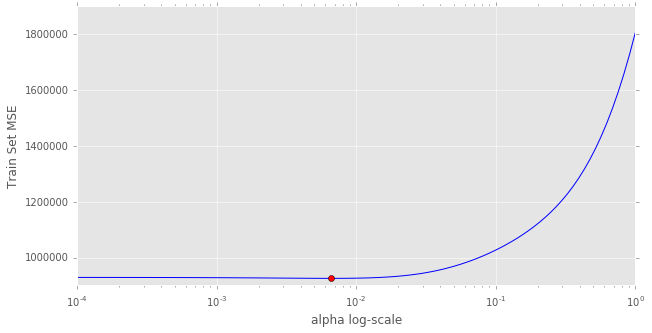

In [162]:
# For ridge regression we will fit ridge models for a range of alphas and select the model with the lowest
# training error rate. Using this optimal alpha we will then predict number of applications and compare
# with the test_set.

# Fit ridge regression over a range of possible alphas
alphas = np.logspace(-4, 0, 100)
# Build estimator
ridge_cv = RidgeCV(alphas = alphas, normalize=True, store_cv_values=True)
# Fit model
results = ridge_cv.fit(X_train.values, y_train.values)

# the results contains a np array [num_samples,num_alphas] a form of LOOCV was performed so 
# the mean(axis=0) is the average MSE for a given alpha
cvs = np.mean(results.cv_values_, axis=0)
# get the minimum error rate and get the optimum alpha
min_cvs = np.min(cvs)
min_alpha = results.alpha_

# Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas,np.mean(results.cv_values_,axis=0), color='b')
ax.plot(min_alpha, min_cvs, color='r', marker='o',)
ax.set_xscale('log')
ax.set_xlabel('alpha log-scale');
ax.set_ylabel('Train Set MSE');

In [163]:
# Get the ridge models predictions on the test set
ridge_predicted = results.predict(df_test[features].values)

# Get the MSE of the Ridges predictions
Ridge_MSE = np.mean((df_test.Apps.values-ridge_predicted)**2)
print("The Ridge Model Test MSE = ", Ridge_MSE, '\n')

print(pd.Series(data = np.hstack([results.intercept_,results.coef_]), index=['Intercept'] + features))

The Ridge Model Test MSE =  1953825.65345 

Intercept     -1062.694072
Private        -684.649474
Accept            1.058455
Enroll            0.334379
Top10perc        38.852495
Top25perc        -9.697783
F.Undergrad       0.005961
P.Undergrad       0.055038
Outstate         -0.024309
Room.Board        0.177457
Books             0.281210
Personal         -0.029562
PhD              -4.390837
Terminal         -4.765855
S.F.Ratio        19.370603
perc.alumni      -5.691326
Expend            0.062184
Grad.Rate        11.416957
dtype: float64


## Fit Lasso Model

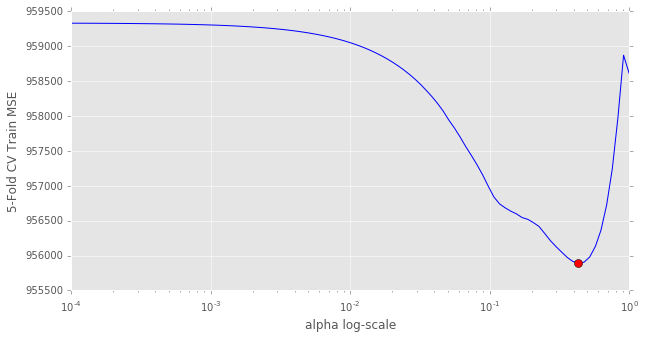

In [164]:
# Use LassoCV to perform 5-fold cross validation to determine optimal alpha
lasso_cv = LassoCV(alphas = np.logspace(-4,0,100), normalize=True, cv=5, max_iter=100000)
lasso_cv.fit(X_train.values, y_train.values)

# The mse estimates are the mean aross folds (cols)
mses = np.mean(lasso_cv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lasso_cv.alphas_,mses, color='b');
ax.plot(lasso_cv.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('5-Fold CV Train MSE');

In [165]:
# Get the lasso model predictions on the test set
lasso_predicted = lasso_cv.predict(df_test[features].values)

# Get the MSE of the lasso predictions
Lasso_MSE = np.mean((df_test.Apps.values-lasso_predicted)**2)
print("The Lasso Model Test MSE = ", Lasso_MSE,'\n')
print('Alpha = ', lasso_cv.alpha_,'\n')
print(pd.Series(data = np.hstack([lasso_cv.intercept_,lasso_cv.coef_]), index=['Intercept'] + features))

The Lasso Model Test MSE =  1860777.35866 

Alpha =  0.432876128108 

Intercept     -1006.260175
Private        -671.472978
Accept            1.123507
Enroll            0.195411
Top10perc        35.843090
Top25perc        -6.979835
F.Undergrad       0.002698
P.Undergrad       0.048355
Outstate         -0.021418
Room.Board        0.158239
Books             0.223854
Personal         -0.008984
PhD              -3.480322
Terminal         -4.468332
S.F.Ratio        16.709474
perc.alumni      -4.605209
Expend            0.058739
Grad.Rate         9.534166
dtype: float64


## Fit a PCR Model